# Funding Rate Factor Analysis

Comprehensive analysis of the funding rate factor for cryptocurrency trading.

## Methodology
- **Factor Signal**: Funding rate percentile ranks (contrarian: long negative, short positive)
- **Portfolio**: Long bottom 20% (most negative funding), short top 20% (most positive funding)
- **Rebalancing**: Daily
- **Weighting**: Equal weight within each leg
- **Universe**: Dynamic - all coins with available data each day

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from binance_data_loader import BinanceDataLoader
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## 1. Data Loading and Preparation

In [2]:
# Load data
data_loader = BinanceDataLoader(
    data_directory=r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020",
    funding_rate_directory=r"C:\Users\USER\Documents\Binance_related\fundingratedata2022",
    min_records=30,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

print("Data loaded successfully!")

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 567 USDT trading pairs
✓ BTCUSDT loaded successfully with 1383 records, avg volume: 347,594
Loaded 530 cryptocurrencies
Filtered 35 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 529 tickers over 1383 dates...
Precomputed returns matrix shape: (1383, 529)
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00
Loading funding rate data from C:\Users\USER\Documents\Binance_related\fundingratedata2022...
Found 567 funding rate files
Loaded funding rates for 529 symbols
Data loaded successfully!


In [3]:
# Get price and funding rate matrices
price = data_loader.get_price_matrix()
funding_rates = data_loader.get_funding_rate_matrix()

print(f"Price matrix shape: {price.shape}")
print(f"Funding rate matrix shape: {funding_rates.shape}")

# Align data - preserve chronological order
common_symbols = list(set(price.columns) & set(funding_rates.columns))
price_dates = set(price.index)
funding_dates = set(funding_rates.index)
common_dates_set = price_dates & funding_dates

# Keep chronological order from price data
common_dates = [date for date in price.index if date in common_dates_set]

print(f"Common symbols: {len(common_symbols)}")
print(f"Common dates: {len(common_dates)}")
print(f"Date range: {common_dates[0]} to {common_dates[-1]}")

# Aligned matrices
price_aligned = price.loc[common_dates, common_symbols].sort_index()
funding_aligned = funding_rates.loc[common_dates, common_symbols].sort_index()

print(f"\nAligned data shapes:")
print(f"Price: {price_aligned.shape}")
print(f"Funding: {funding_aligned.shape}")

Building funding rate matrix with 1383 dates and 529 tickers
Funding rate matrix final shape: (1383, 529)
Price matrix shape: (1383, 529)
Funding rate matrix shape: (1383, 529)
Common symbols: 529
Common dates: 1383
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00

Aligned data shapes:
Price: (1383, 529)
Funding: (1383, 529)


## 2. Factor Construction

In [4]:
# Create factor signals
funding_ranks = funding_aligned.rank(axis=1, pct=True, method='dense')
funding_zscore = funding_aligned.subtract(funding_aligned.mean(axis=1), axis=0).div(funding_aligned.std(axis=1), axis=0)

# Create quintile portfolios
funding_quintiles = pd.DataFrame(index=funding_aligned.index, columns=funding_aligned.columns)
for date in funding_aligned.index:
    day_ranks = funding_ranks.loc[date].dropna()
    if len(day_ranks) >= 5:  # Need at least 5 coins for quintiles
        try:
            quintiles = pd.qcut(day_ranks, 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], duplicates='drop')
            funding_quintiles.loc[date, quintiles.index] = quintiles.values
        except ValueError:
            # Skip days where quintiles can't be created due to insufficient unique values
            continue

print("Factor signals created:")
print(f"- Funding rate ranks: {funding_ranks.shape}")
print(f"- Funding rate z-scores: {funding_zscore.shape}")
print(f"- Quintile portfolios: {funding_quintiles.shape}")

# Summary statistics
print(f"\nFunding rate statistics:")
print(funding_aligned.describe())

Factor signals created:
- Funding rate ranks: (1383, 529)
- Funding rate z-scores: (1383, 529)
- Quintile portfolios: (1383, 529)

Funding rate statistics:
        WLFIUSDT     SEIUSDT     ALTUSDT    PNUTUSDT      XEMUSDT  \
count  52.000000  790.000000  628.000000  337.000000  1266.000000   
mean    0.000040   -0.000020    0.000042    0.000034    -0.000084   
std     0.000083    0.000350    0.000162    0.000095     0.001191   
min    -0.000384   -0.004018   -0.001736   -0.000466    -0.021010   
25%     0.000050   -0.000137    0.000050    0.000030     0.000100   
50%     0.000050    0.000081    0.000050    0.000050     0.000100   
75%     0.000050    0.000100    0.000050    0.000050     0.000100   
max     0.000294    0.001057    0.000811    0.000443     0.001379   

          ALGOUSDT      APEUSDT     ATHUSDT   ANIMEUSDT      ONTUSDT  ...  \
count  1383.000000  1307.000000  195.000000  264.000000  1383.000000  ...   
mean      0.000063    -0.000049   -0.000022   -0.000176     0.000020

## 3. Factor Performance Analysis

In [5]:
def calculate_quintile_returns(ranks_df, price_df, quintiles_df):
    """
    Calculate returns for each quintile separately, then combine into portfolio
    """
    quintile_returns = {f'Q{i}': [] for i in range(1, 6)}
    portfolio_returns = []
    portfolio_details = []
    
    for i in range(len(ranks_df) - 1):
        date = ranks_df.index[i]
        next_date = ranks_df.index[i + 1]
        
        # Get quintile assignments for today
        day_quintiles = quintiles_df.loc[date].dropna()
        
        if len(day_quintiles) < 10:  # Need minimum coins
            for q in range(1, 6):
                quintile_returns[f'Q{q}'].append(np.nan)
            portfolio_returns.append(np.nan)
            continue
        
        # Calculate returns for each quintile
        quintile_rets = {}
        quintile_details = {'date': date}
        
        for q in range(1, 6):
            quintile_name = f'Q{q}'
            quintile_coins = day_quintiles[day_quintiles == quintile_name].index
            
            if len(quintile_coins) == 0:
                quintile_rets[quintile_name] = np.nan
                quintile_details[f'{quintile_name}_coins'] = 0
                quintile_details[f'{quintile_name}_return'] = np.nan
                continue
            
            # Calculate returns for coins in this quintile
            coin_returns = []
            for coin in quintile_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        coin_returns.append((p1 - p0) / p0)
            
            # Equal weight average for quintile
            if len(coin_returns) > 0:
                quintile_ret = np.mean(coin_returns)
                quintile_rets[quintile_name] = quintile_ret
                quintile_details[f'{quintile_name}_coins'] = len(coin_returns)
                quintile_details[f'{quintile_name}_return'] = quintile_ret
            else:
                quintile_rets[quintile_name] = np.nan
                quintile_details[f'{quintile_name}_coins'] = 0
                quintile_details[f'{quintile_name}_return'] = np.nan
        
        # Store quintile returns
        for q in range(1, 6):
            quintile_returns[f'Q{q}'].append(quintile_rets.get(f'Q{q}', np.nan))
        
        # Calculate portfolio return (Long Q1, Short Q5)
        q1_ret = quintile_rets.get('Q1', np.nan)
        q5_ret = quintile_rets.get('Q5', np.nan)
        
        if pd.notna(q1_ret) and pd.notna(q5_ret):
            # Long Q1 (most negative funding), Short Q5 (most positive funding)
            portfolio_return = q1_ret - q5_ret - 0.0005  # 5bps transaction costs
        else:
            portfolio_return = np.nan
        
        portfolio_returns.append(portfolio_return)
        quintile_details['portfolio_return'] = portfolio_return
        portfolio_details.append(quintile_details)
    
    # Convert to DataFrames
    quintile_df = pd.DataFrame(quintile_returns, index=ranks_df.index[:-1])
    portfolio_series = pd.Series(portfolio_returns, index=ranks_df.index[:-1])
    details_df = pd.DataFrame(portfolio_details).set_index('date')
    
    return quintile_df, portfolio_series, details_df

def calculate_factor_returns_all_quintiles(ranks_df, price_df, long_pct=0.2, short_pct=0.2):
    """
    Alternative method: Calculate returns using percentile thresholds for all quintiles
    """
    quintile_returns = {f'Q{i}': [] for i in range(1, 6)}
    portfolio_returns = []
    portfolio_details = []
    
    for i in range(len(ranks_df) - 1):
        date = ranks_df.index[i]
        next_date = ranks_df.index[i + 1]
        
        # Get ranks for today
        day_ranks = ranks_df.iloc[i].dropna()
        
        if len(day_ranks) < 10:  # Need minimum coins
            for q in range(1, 6):
                quintile_returns[f'Q{q}'].append(np.nan)
            portfolio_returns.append(np.nan)
            continue
        
        # Define quintile breakpoints
        breakpoints = [day_ranks.quantile(i/5) for i in range(6)]
        
        quintile_rets = {}
        quintile_details = {'date': date}
        
        for q in range(1, 6):
            # Get coins in this quintile
            if q == 1:
                quintile_coins = day_ranks[day_ranks <= breakpoints[1]].index
            elif q == 5:
                quintile_coins = day_ranks[day_ranks > breakpoints[4]].index
            else:
                quintile_coins = day_ranks[(day_ranks > breakpoints[q-1]) & (day_ranks <= breakpoints[q])].index
            
            quintile_name = f'Q{q}'
            
            if len(quintile_coins) == 0:
                quintile_rets[quintile_name] = np.nan
                quintile_details[f'{quintile_name}_coins'] = 0
                quintile_details[f'{quintile_name}_return'] = np.nan
                continue
            
            # Calculate returns for coins in this quintile
            coin_returns = []
            for coin in quintile_coins:
                if coin in price_df.columns:
                    p0 = price_df.loc[date, coin]
                    p1 = price_df.loc[next_date, coin]
                    if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                        coin_returns.append((p1 - p0) / p0)
            
            # Equal weight average for quintile
            if len(coin_returns) > 0:
                quintile_ret = np.mean(coin_returns)
                quintile_rets[quintile_name] = quintile_ret
                quintile_details[f'{quintile_name}_coins'] = len(coin_returns)
                quintile_details[f'{quintile_name}_return'] = quintile_ret
            else:
                quintile_rets[quintile_name] = np.nan
                quintile_details[f'{quintile_name}_coins'] = 0
                quintile_details[f'{quintile_name}_return'] = np.nan
        
        # Store quintile returns
        for q in range(1, 6):
            quintile_returns[f'Q{q}'].append(quintile_rets.get(f'Q{q}', np.nan))
        
        # Calculate portfolio return (Long Q1, Short Q5)
        q1_ret = quintile_rets.get('Q1', np.nan)
        q5_ret = quintile_rets.get('Q5', np.nan)
        
        if pd.notna(q1_ret) and pd.notna(q5_ret):
            # Long Q1 (most negative funding), Short Q5 (most positive funding)
            portfolio_return = q1_ret - q5_ret - 0.0005  # 5bps transaction costs
        else:
            portfolio_return = np.nan
        
        portfolio_returns.append(portfolio_return)
        quintile_details['portfolio_return'] = portfolio_return
        portfolio_details.append(quintile_details)
    
    # Convert to DataFrames
    quintile_df = pd.DataFrame(quintile_returns, index=ranks_df.index[:-1])
    portfolio_series = pd.Series(portfolio_returns, index=ranks_df.index[:-1])
    details_df = pd.DataFrame(portfolio_details).set_index('date')
    
    return quintile_df, portfolio_series, details_df

# Calculate quintile returns using both methods
print("Calculating quintile-based returns...")

# Method 1: Using pre-computed quintiles (may have missing days)
try:
    quintile_returns_1, factor_returns_1, portfolio_details_1 = calculate_quintile_returns(
        funding_ranks, price_aligned, funding_quintiles)
    print("Method 1 (pre-computed quintiles) completed")
except Exception as e:
    print(f"Method 1 failed: {e}")
    quintile_returns_1 = None

# Method 2: Using percentile breakpoints (more robust)
quintile_returns_2, factor_returns_2, portfolio_details_2 = calculate_factor_returns_all_quintiles(
    funding_ranks, price_aligned)
print("Method 2 (percentile breakpoints) completed")

# Use the more robust method
quintile_returns = quintile_returns_2
factor_returns = factor_returns_2
portfolio_details = portfolio_details_2

print(f"\nQuintile Returns Summary:")
print(f"Data points: {len(factor_returns)}")
print(f"Valid portfolio returns: {factor_returns.notna().sum()}")
print(f"\nQuintile return statistics (annualized):")

for q in range(1, 6):
    q_name = f'Q{q}'
    q_clean = quintile_returns[q_name].dropna()
    if len(q_clean) > 0:
        q_annual_ret = q_clean.mean() * 365
        q_annual_vol = q_clean.std() * np.sqrt(365)
        q_sharpe = q_annual_ret / q_annual_vol if q_annual_vol != 0 else 0
        print(f"{q_name}: Return={q_annual_ret:.2%}, Vol={q_annual_vol:.2%}, Sharpe={q_sharpe:.3f}")

print(f"\nPortfolio details (average):")
numeric_cols = [col for col in portfolio_details.columns if 'coins' in col or 'return' in col]
print(portfolio_details[numeric_cols].describe())

Calculating quintile-based returns...
Method 1 (pre-computed quintiles) completed
Method 2 (percentile breakpoints) completed

Quintile Returns Summary:
Data points: 1382
Valid portfolio returns: 870

Quintile return statistics (annualized):
Q1: Return=-2.67%, Vol=82.45%, Sharpe=-0.032
Q2: Return=38.39%, Vol=81.71%, Sharpe=0.470
Q3: Return=29.91%, Vol=86.79%, Sharpe=0.345
Q4: Return=113.37%, Vol=89.33%, Sharpe=1.269
Q5: Return=49.74%, Vol=125.23%, Sharpe=0.397

Portfolio details (average):
          Q1_coins    Q1_return     Q2_coins   Q2_return     Q3_coins  \
count  1382.000000  1382.000000  1382.000000  992.000000  1382.000000   
mean     85.187410    -0.000073    63.578148    0.001052    41.376990   
std      72.145482     0.043155    69.172815    0.042768    53.755869   
min      22.000000    -0.276781     0.000000   -0.254397     0.000000   
25%      31.000000    -0.022885     0.000000   -0.020659     0.000000   
50%      56.000000     0.001883    34.000000    0.002980    16.0000

=== FUNDING RATE FACTOR PERFORMANCE ===
Portfolio (Q1 Long - Q5 Short):
Annual Return: -47.95%
Annual Volatility: 88.23%
Sharpe Ratio: -0.543
Maximum Drawdown: -128.74%
Hit Rate: 50.46%
Skewness: -2.265
Kurtosis: 25.833
Tail Ratio (95th/5th): 0.90


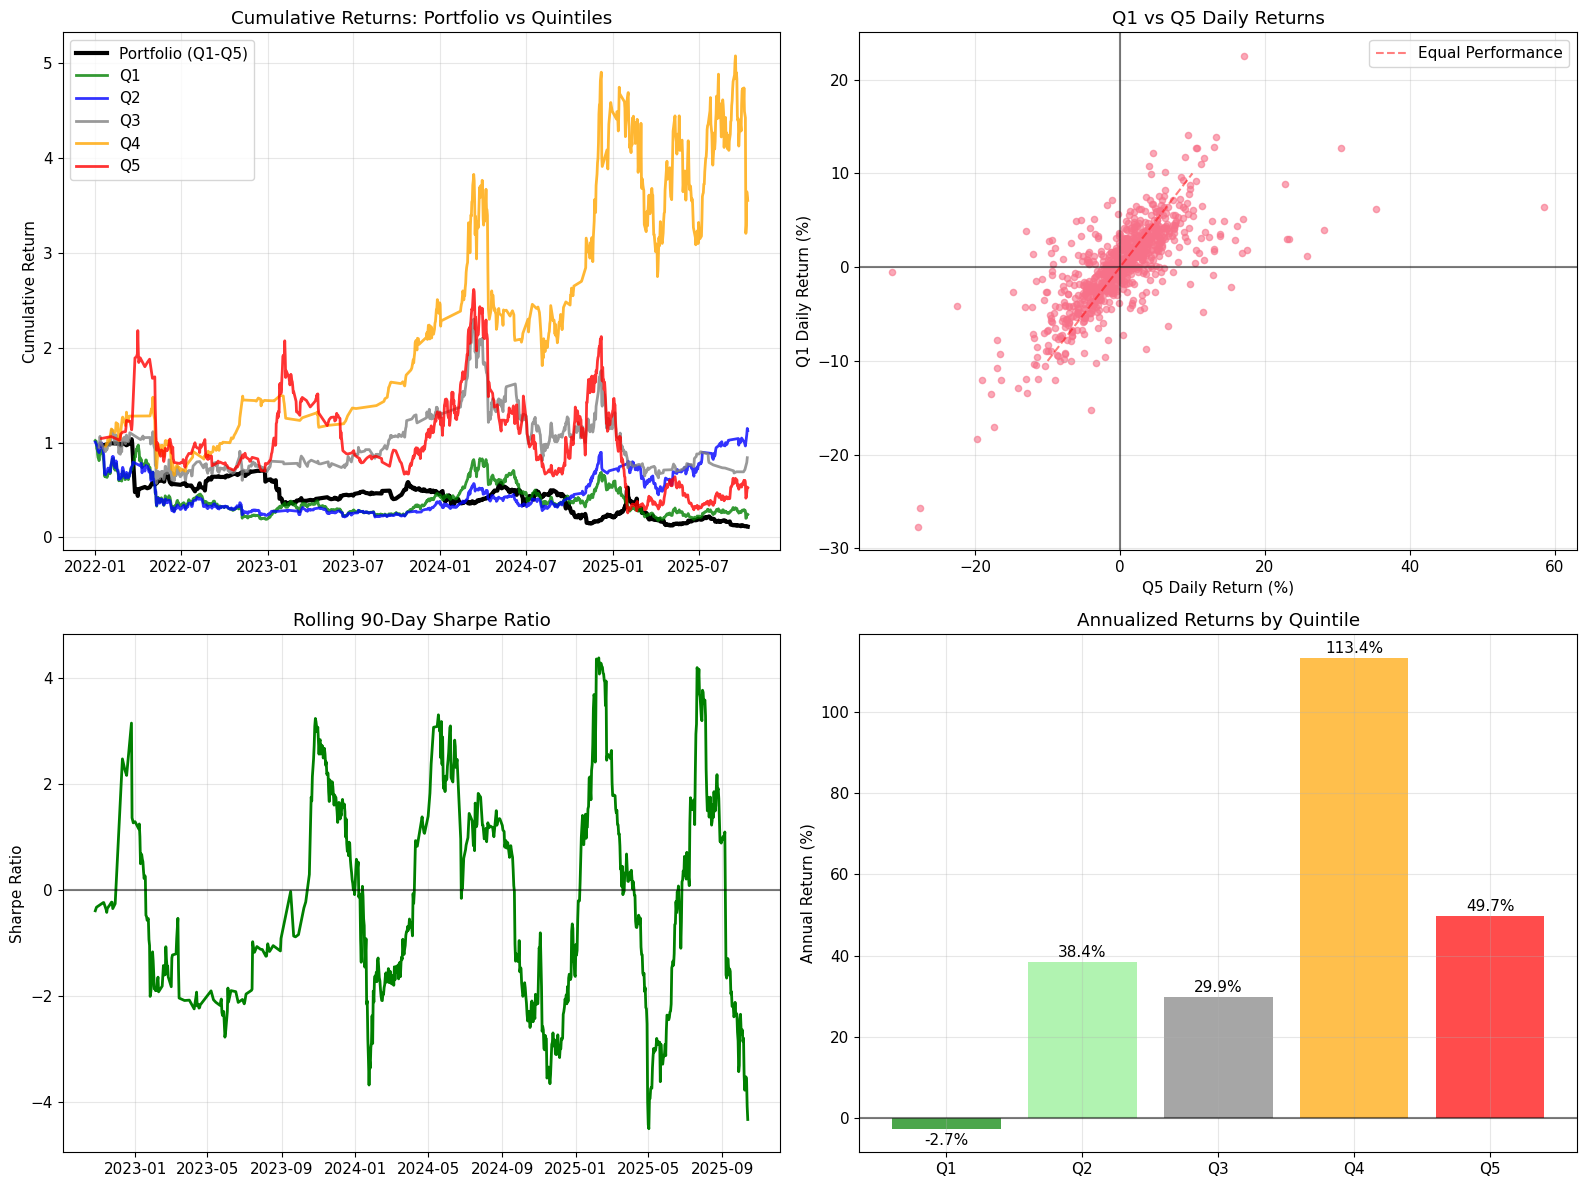


=== QUINTILE ANALYSIS ===
Quintile   Annual Ret   Annual Vol   Sharpe     Avg Coins 
-----------------------------------------------------------------
Q1         -2.67%       82.45%       -0.032     85.2      
Q2         38.39%       81.71%       0.470      63.6      
Q3         29.91%       86.79%       0.345      41.4      
Q4         113.37%      89.33%       1.269      32.5      
Q5         49.74%       125.23%      0.397      14.8      

=== MONOTONICITY TEST ===
Expected pattern: Q1 > Q2 > Q3 > Q4 > Q5 (for contrarian factor)
Monotonic decreasing: ✗
Q1-Q5 Spread: -52.41%
Portfolio Return: -47.95% (should ≈ Q1-Q5 spread)

=== TRANSACTION COST ANALYSIS ===
Gross Return (before costs): -29.70%
Net Return (after costs): -47.95%
Transaction Cost Impact: 18.25%


In [6]:
# Performance metrics (using 365-day annualization)
factor_returns_clean = factor_returns.dropna()

# Basic statistics
annual_return = factor_returns_clean.mean() * 365
annual_vol = factor_returns_clean.std() * np.sqrt(365)
sharpe_ratio = annual_return / annual_vol

# Additional metrics
max_dd = (factor_returns_clean.cumsum() - factor_returns_clean.cumsum().cummax()).min()
hit_rate = (factor_returns_clean > 0).mean()
skewness = factor_returns_clean.skew()
kurtosis = factor_returns_clean.kurtosis()

# Tail ratios
percentile_95 = factor_returns_clean.quantile(0.95)
percentile_5 = factor_returns_clean.quantile(0.05)
tail_ratio = abs(percentile_95 / percentile_5)

print("=== FUNDING RATE FACTOR PERFORMANCE ===")
print(f"Portfolio (Q1 Long - Q5 Short):")
print(f"Annual Return: {annual_return:.2%}")
print(f"Annual Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Maximum Drawdown: {max_dd:.2%}")
print(f"Hit Rate: {hit_rate:.2%}")
print(f"Skewness: {skewness:.3f}")
print(f"Kurtosis: {kurtosis:.3f}")
print(f"Tail Ratio (95th/5th): {tail_ratio:.2f}")

# Cumulative returns for portfolio and all quintiles
cumulative_returns = (1 + factor_returns_clean).cumprod()
quintile_cumulative = {}
for q in range(1, 6):
    q_name = f'Q{q}'
    q_clean = quintile_returns[q_name].dropna()
    if len(q_clean) > 0:
        quintile_cumulative[q_name] = (1 + q_clean).cumprod()

# Plot performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cumulative returns - Portfolio and Quintiles
axes[0,0].plot(cumulative_returns.index, cumulative_returns.values, linewidth=3, color='black', label='Portfolio (Q1-Q5)')
colors = ['green', 'blue', 'gray', 'orange', 'red']
for i, (q_name, q_cum) in enumerate(quintile_cumulative.items()):
    axes[0,0].plot(q_cum.index, q_cum.values, linewidth=2, color=colors[i], alpha=0.8, label=q_name)
axes[0,0].set_title('Cumulative Returns: Portfolio vs Quintiles')
axes[0,0].set_ylabel('Cumulative Return')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Quintile Return Spread (Q1 vs Q5)
q1_clean = quintile_returns['Q1'].dropna()
q5_clean = quintile_returns['Q5'].dropna()
if len(q1_clean) > 0 and len(q5_clean) > 0:
    common_dates = q1_clean.index.intersection(q5_clean.index)
    q1_aligned = q1_clean.reindex(common_dates)
    q5_aligned = q5_clean.reindex(common_dates)
    
    axes[0,1].scatter(q5_aligned * 100, q1_aligned * 100, alpha=0.6, s=20)
    axes[0,1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.5)
    axes[0,1].plot([-10, 10], [-10, 10], 'r--', alpha=0.5, label='Equal Performance')
    axes[0,1].set_xlabel('Q5 Daily Return (%)')
    axes[0,1].set_ylabel('Q1 Daily Return (%)')
    axes[0,1].set_title('Q1 vs Q5 Daily Returns')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

# Rolling Sharpe ratio (90-day)
rolling_sharpe = factor_returns_clean.rolling(90).apply(lambda x: (x.mean() * 365) / (x.std() * np.sqrt(365)))
axes[1,0].plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2, color='green')
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_title('Rolling 90-Day Sharpe Ratio')
axes[1,0].set_ylabel('Sharpe Ratio')
axes[1,0].grid(True, alpha=0.3)

# Quintile Performance Summary (Bar Chart)
quintile_stats = []
for q in range(1, 6):
    q_name = f'Q{q}'
    q_clean = quintile_returns[q_name].dropna()
    if len(q_clean) > 0:
        q_annual_ret = q_clean.mean() * 365
        quintile_stats.append((q_name, q_annual_ret))

if quintile_stats:
    q_names, q_returns = zip(*quintile_stats)
    bars = axes[1,1].bar(q_names, [r*100 for r in q_returns], 
                        color=['green', 'lightgreen', 'gray', 'orange', 'red'], alpha=0.7)
    axes[1,1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[1,1].set_title('Annualized Returns by Quintile')
    axes[1,1].set_ylabel('Annual Return (%)')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, ret in zip(bars, q_returns):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + (0.5 if height >= 0 else -1),
                      f'{ret:.1%}', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

# Print quintile analysis
print(f"\n=== QUINTILE ANALYSIS ===")
print(f"{'Quintile':<10} {'Annual Ret':<12} {'Annual Vol':<12} {'Sharpe':<10} {'Avg Coins':<10}")
print("-" * 65)

for q in range(1, 6):
    q_name = f'Q{q}'
    q_clean = quintile_returns[q_name].dropna()
    if len(q_clean) > 0:
        q_annual_ret = q_clean.mean() * 365
        q_annual_vol = q_clean.std() * np.sqrt(365)
        q_sharpe = q_annual_ret / q_annual_vol if q_annual_vol != 0 else 0
        avg_coins = portfolio_details[f'{q_name}_coins'].mean()
        print(f"{q_name:<10} {q_annual_ret:<12.2%} {q_annual_vol:<12.2%} {q_sharpe:<10.3f} {avg_coins:<10.1f}")

# Factor monotonicity test
print(f"\n=== MONOTONICITY TEST ===")
if len(quintile_stats) == 5:
    print("Expected pattern: Q1 > Q2 > Q3 > Q4 > Q5 (for contrarian factor)")
    returns_order = [r for _, r in quintile_stats]
    is_monotonic = all(returns_order[i] >= returns_order[i+1] for i in range(len(returns_order)-1))
    print(f"Monotonic decreasing: {'✓' if is_monotonic else '✗'}")
    
    # Calculate spreads
    q1_ret = returns_order[0]
    q5_ret = returns_order[4]
    spread = q1_ret - q5_ret
    print(f"Q1-Q5 Spread: {spread:.2%}")
    print(f"Portfolio Return: {annual_return:.2%} (should ≈ Q1-Q5 spread)")

print(f"\n=== TRANSACTION COST ANALYSIS ===")
portfolio_gross = factor_returns_clean + 0.0005  # Add back transaction costs
portfolio_gross_annual = portfolio_gross.mean() * 365
transaction_cost_impact = (portfolio_gross_annual - annual_return)
print(f"Gross Return (before costs): {portfolio_gross_annual:.2%}")
print(f"Net Return (after costs): {annual_return:.2%}")
print(f"Transaction Cost Impact: {transaction_cost_impact:.2%}")

## 4. Information Coefficient (IC) Analysis

In [7]:
def calculate_ic(factor_ranks, forward_returns):
    """
    Calculate Information Coefficient (rank correlation between factor and future returns)
    """
    ic_series = []
    
    for i in range(len(factor_ranks) - 1):
        date = factor_ranks.index[i]
        next_date = factor_ranks.index[i + 1]
        
        factor_today = factor_ranks.iloc[i].dropna()
        returns_tomorrow = forward_returns.iloc[i + 1].dropna()
        
        # Get common coins
        common_coins = factor_today.index.intersection(returns_tomorrow.index)
        if len(common_coins) < 10:  # Skip if too few coins
            ic_series.append({'date': date, 'ic': np.nan})
            continue
        
        # Calculate Spearman rank correlation
        try:
            ic = factor_today[common_coins].corr(returns_tomorrow[common_coins], method='spearman')
            ic_series.append({'date': date, 'ic': ic})
        except:
            ic_series.append({'date': date, 'ic': np.nan})
    
    return pd.DataFrame(ic_series).set_index('date')

# Calculate forward returns
forward_returns_1d = price_aligned.pct_change()
forward_returns_5d = price_aligned.pct_change(5)

# Calculate ICs
ic_1d = calculate_ic(funding_ranks, forward_returns_1d)
ic_5d = calculate_ic(funding_ranks, forward_returns_5d)

print("Information Coefficient Analysis")
print("=" * 40)

# IC Statistics for 1-day
ic_1d_clean = ic_1d['ic'].dropna()
ic_mean_1d = ic_1d_clean.mean()
ic_std_1d = ic_1d_clean.std()
ic_ir_1d = ic_mean_1d / ic_std_1d
ic_hit_rate_1d = (ic_1d_clean > 0).mean()
ic_tstat_1d = ic_mean_1d / (ic_std_1d / np.sqrt(len(ic_1d_clean)))

print(f"\n1-Day Forward Returns:")
print(f"IC Mean: {ic_mean_1d:.4f}")
print(f"IC Std: {ic_std_1d:.4f}")
print(f"IC Information Ratio: {ic_ir_1d:.3f}")
print(f"IC Hit Rate: {ic_hit_rate_1d:.2%}")
print(f"IC t-statistic: {ic_tstat_1d:.3f}")

# IC Statistics for 5-day
ic_5d_clean = ic_5d['ic'].dropna()
ic_mean_5d = ic_5d_clean.mean()
ic_std_5d = ic_5d_clean.std()
ic_ir_5d = ic_mean_5d / ic_std_5d
ic_hit_rate_5d = (ic_5d_clean > 0).mean()
ic_tstat_5d = ic_mean_5d / (ic_std_5d / np.sqrt(len(ic_5d_clean)))

print(f"\n5-Day Forward Returns:")
print(f"IC Mean: {ic_mean_5d:.4f}")
print(f"IC Std: {ic_std_5d:.4f}")
print(f"IC Information Ratio: {ic_ir_5d:.3f}")
print(f"IC Hit Rate: {ic_hit_rate_5d:.2%}")
print(f"IC t-statistic: {ic_tstat_5d:.3f}")

Information Coefficient Analysis

1-Day Forward Returns:
IC Mean: 0.0135
IC Std: 0.1049
IC Information Ratio: 0.128
IC Hit Rate: 56.30%
IC t-statistic: 4.770

5-Day Forward Returns:
IC Mean: 0.0146
IC Std: 0.1128
IC Information Ratio: 0.130
IC Hit Rate: 55.88%
IC t-statistic: 4.810


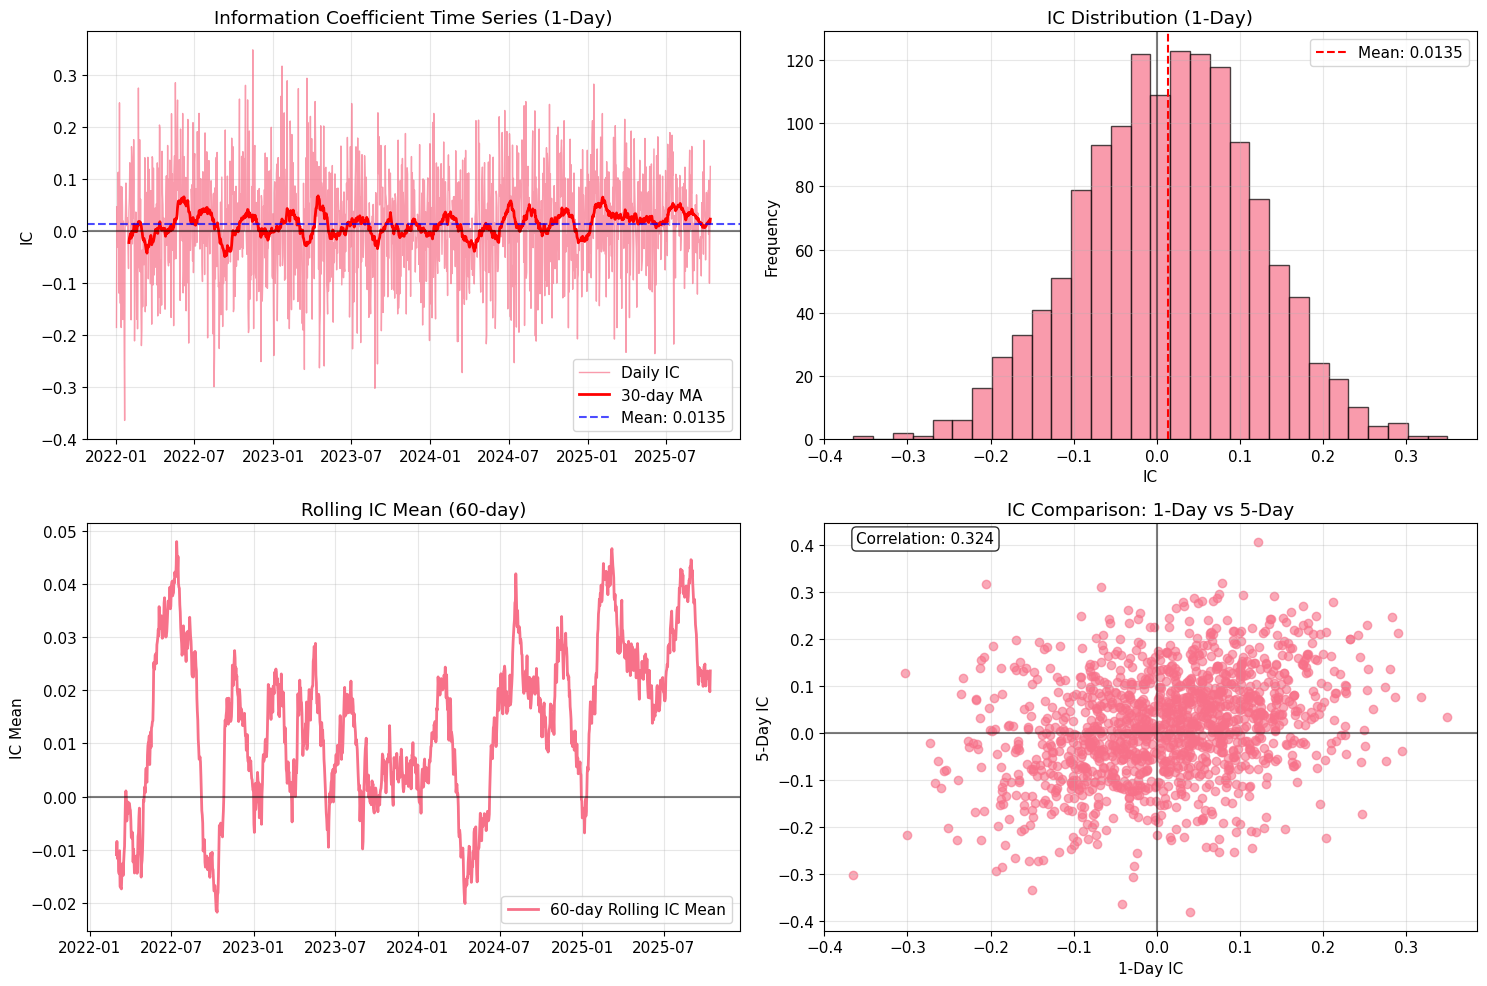

In [8]:
# Plot IC analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# IC time series
axes[0,0].plot(ic_1d.index, ic_1d['ic'], alpha=0.7, linewidth=1, label='Daily IC')
axes[0,0].plot(ic_1d.index, ic_1d['ic'].rolling(30).mean(), linewidth=2, color='red', label='30-day MA')
axes[0,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[0,0].axhline(ic_mean_1d, color='blue', linestyle='--', alpha=0.7, label=f'Mean: {ic_mean_1d:.4f}')
axes[0,0].set_title('Information Coefficient Time Series (1-Day)')
axes[0,0].set_ylabel('IC')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# IC distribution
axes[0,1].hist(ic_1d_clean, bins=30, alpha=0.7, edgecolor='black')
axes[0,1].axvline(ic_mean_1d, color='red', linestyle='--', label=f'Mean: {ic_mean_1d:.4f}')
axes[0,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[0,1].set_title('IC Distribution (1-Day)')
axes[0,1].set_xlabel('IC')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Rolling IC statistics
rolling_ic_mean = ic_1d['ic'].rolling(60).mean()
rolling_ic_std = ic_1d['ic'].rolling(60).std()
rolling_ic_ir = rolling_ic_mean / rolling_ic_std

axes[1,0].plot(rolling_ic_mean.index, rolling_ic_mean, linewidth=2, label='60-day Rolling IC Mean')
axes[1,0].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,0].set_title('Rolling IC Mean (60-day)')
axes[1,0].set_ylabel('IC Mean')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# IC comparison (1-day vs 5-day)
axes[1,1].scatter(ic_1d['ic'], ic_5d['ic'], alpha=0.6)
axes[1,1].axhline(0, color='black', linestyle='-', alpha=0.5)
axes[1,1].axvline(0, color='black', linestyle='-', alpha=0.5)
axes[1,1].set_xlabel('1-Day IC')
axes[1,1].set_ylabel('5-Day IC')
axes[1,1].set_title('IC Comparison: 1-Day vs 5-Day')
axes[1,1].grid(True, alpha=0.3)

# Add correlation coefficient
ic_corr = ic_1d['ic'].corr(ic_5d['ic'])
axes[1,1].text(0.05, 0.95, f'Correlation: {ic_corr:.3f}', transform=axes[1,1].transAxes, 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 5. Market Regime Analysis

In [9]:
# Define market regimes based on BTC 90-day returns
btc_90d_returns = price_aligned['BTCUSDT'].pct_change(90)
bull_market = btc_90d_returns >= 0
bear_market = btc_90d_returns < 0

# Align with factor returns dates
bull_market_aligned = bull_market.reindex(factor_returns.index)
bear_market_aligned = bear_market.reindex(factor_returns.index)

# Factor performance by regime
factor_returns_bull = factor_returns[bull_market_aligned].dropna()
factor_returns_bear = factor_returns[bear_market_aligned].dropna()

print("Market Regime Analysis")
print("=" * 30)
print(f"Total trading days: {len(factor_returns.dropna())}")
print(f"Bull market days: {len(factor_returns_bull)}")
print(f"Bear market days: {len(factor_returns_bear)}")

if len(factor_returns_bull) > 0:
    bull_annual_return = factor_returns_bull.mean() * 365
    bull_annual_vol = factor_returns_bull.std() * np.sqrt(365)
    bull_sharpe = bull_annual_return / bull_annual_vol
    bull_hit_rate = (factor_returns_bull > 0).mean()
    
    print(f"\nBull Market Performance:")
    print(f"Annual Return: {bull_annual_return:.2%}")
    print(f"Annual Volatility: {bull_annual_vol:.2%}")
    print(f"Sharpe Ratio: {bull_sharpe:.3f}")
    print(f"Hit Rate: {bull_hit_rate:.2%}")

if len(factor_returns_bear) > 0:
    bear_annual_return = factor_returns_bear.mean() * 365
    bear_annual_vol = factor_returns_bear.std() * np.sqrt(365)
    bear_sharpe = bear_annual_return / bear_annual_vol
    bear_hit_rate = (factor_returns_bear > 0).mean()
    
    print(f"\nBear Market Performance:")
    print(f"Annual Return: {bear_annual_return:.2%}")
    print(f"Annual Volatility: {bear_annual_vol:.2%}")
    print(f"Sharpe Ratio: {bear_sharpe:.3f}")
    print(f"Hit Rate: {bear_hit_rate:.2%}")

# IC by regime
ic_bull = ic_1d.loc[bull_market_aligned[bull_market_aligned].index]['ic'].dropna()
ic_bear = ic_1d.loc[bear_market_aligned[bear_market_aligned].index]['ic'].dropna()

if len(ic_bull) > 0:
    print(f"\nIC in Bull Markets:")
    print(f"Mean IC: {ic_bull.mean():.4f}")
    print(f"IC Hit Rate: {(ic_bull > 0).mean():.2%}")

if len(ic_bear) > 0:
    print(f"\nIC in Bear Markets:")
    print(f"Mean IC: {ic_bear.mean():.4f}")
    print(f"IC Hit Rate: {(ic_bear > 0).mean():.2%}")

Market Regime Analysis
Total trading days: 870
Bull market days: 619
Bear market days: 237

Bull Market Performance:
Annual Return: -6.10%
Annual Volatility: 74.93%
Sharpe Ratio: -0.081
Hit Rate: 50.57%

Bear Market Performance:
Annual Return: -89.46%
Annual Volatility: 98.07%
Sharpe Ratio: -0.912
Hit Rate: 50.63%

IC in Bull Markets:
Mean IC: 0.0145
IC Hit Rate: 56.77%

IC in Bear Markets:
Mean IC: 0.0159
IC Hit Rate: 56.68%


## 6. Momentum Factor Comparison

In [10]:
def calculate_momentum_factor(price_data, lookback_days):
    """
    Calculate momentum factor: (price_t - price_t-n) / price_t-n
    Returns percentile ranks
    """
    momentum_returns = price_data.pct_change(lookback_days)
    return momentum_returns.rank(axis=1, pct=True)

# Calculate momentum factors for different horizons
momentum_factors = {
    'mom_5d': calculate_momentum_factor(price_aligned, 5),
    'mom_21d': calculate_momentum_factor(price_aligned, 21),
    'mom_60d': calculate_momentum_factor(price_aligned, 60)
}

# Calculate correlations between funding rate and momentum factors
factor_correlations = {}

for mom_name, mom_factor in momentum_factors.items():
    # Align dates
    common_dates_mom = funding_ranks.index.intersection(mom_factor.index)
    
    # Calculate daily cross-sectional correlations
    daily_correls = []
    for date in common_dates_mom:
        funding_day = funding_ranks.loc[date].dropna()
        mom_day = mom_factor.loc[date].dropna()
        
        common_coins = funding_day.index.intersection(mom_day.index)
        if len(common_coins) >= 10:
            corr = funding_day[common_coins].corr(mom_day[common_coins])
            daily_correls.append(corr)
    
    if daily_correls:
        factor_correlations[mom_name] = {
            'mean_corr': np.mean(daily_correls),
            'std_corr': np.std(daily_correls),
            'daily_correls': daily_correls
        }

print("Funding Rate vs Momentum Factor Correlations")
print("=" * 50)
for factor_name, corr_stats in factor_correlations.items():
    print(f"{factor_name}: {corr_stats['mean_corr']:.4f} ± {corr_stats['std_corr']:.4f}")

# Calculate momentum factor returns for comparison
momentum_returns = {}
for mom_name, mom_factor in momentum_factors.items():
    # Use the same function we defined earlier
    mom_quintile_ret, mom_portfolio_ret, _ = calculate_factor_returns_all_quintiles(mom_factor, price_aligned)
    momentum_returns[mom_name] = mom_portfolio_ret.dropna()

# Performance comparison
print(f"\nFactor Performance Comparison (Annualized):")
print(f"{'Factor':<15} {'Return':<10} {'Vol':<10} {'Sharpe':<10}")
print("-" * 50)

# Funding rate factor
fund_ret = factor_returns_clean.mean() * 365
fund_vol = factor_returns_clean.std() * np.sqrt(365)
fund_sharpe = fund_ret / fund_vol
print(f"{'Funding Rate':<15} {fund_ret:<10.2%} {fund_vol:<10.2%} {fund_sharpe:<10.3f}")

# Momentum factors
for mom_name, mom_ret in momentum_returns.items():
    if len(mom_ret) > 0:
        ret = mom_ret.mean() * 365
        vol = mom_ret.std() * np.sqrt(365)
        sharpe = ret / vol if vol != 0 else 0
        print(f"{mom_name:<15} {ret:<10.2%} {vol:<10.2%} {sharpe:<10.3f}")

Funding Rate vs Momentum Factor Correlations
mom_5d: 0.0020 ± 0.1123
mom_21d: -0.0216 ± 0.1242
mom_60d: -0.0304 ± 0.1233

Factor Performance Comparison (Annualized):
Factor          Return     Vol        Sharpe    
--------------------------------------------------
Funding Rate    -47.95%    88.23%     -0.543    
mom_5d          3.28%      44.56%     0.074     
mom_21d         3.67%      44.32%     0.083     
mom_60d         5.38%      40.82%     0.132     


## 7. Factor Decay Analysis

Factor Decay Analysis
Hold Days  Mean Ret     Annual Ret   Annual Vol   Sharpe     N Periods 
------------------------------------------------------------
1          -0.0002      -7.32%       21.34%       -0.343     1382      
2          -0.0014      -25.39%      21.14%       -1.201     691       
3          -0.0015      -17.80%      22.85%       -0.779     460       
5          -0.0041      -29.95%      20.92%       -1.432     276       
10         -0.0090      -32.79%      18.85%       -1.739     138       


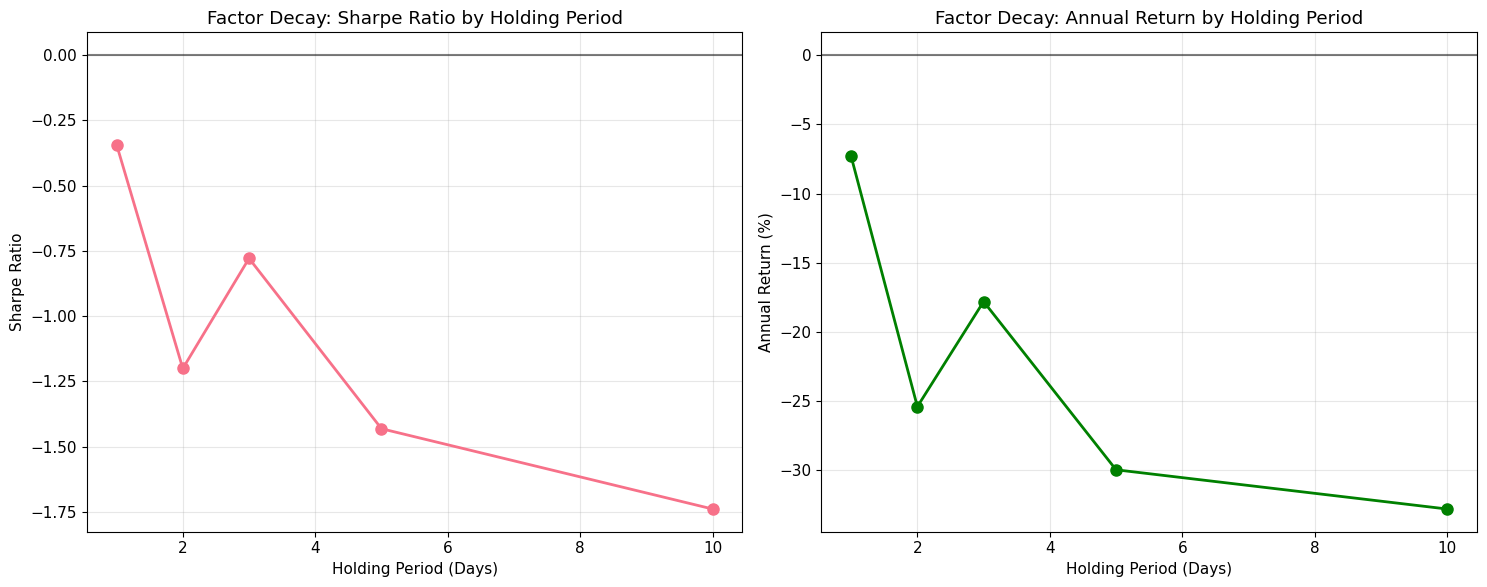

In [11]:
def calculate_factor_returns_with_holding_period(ranks_df, price_df, hold_days=1):
    """
    Calculate factor returns with different holding periods
    """
    factor_returns = []
    
    for i in range(0, len(ranks_df) - hold_days, hold_days):  # Non-overlapping periods
        date = ranks_df.index[i]
        end_date_idx = min(i + hold_days, len(ranks_df) - 1)
        end_date = ranks_df.index[end_date_idx]
        
        # Get ranks for portfolio formation date
        day_ranks = ranks_df.iloc[i].dropna()
        
        if len(day_ranks) < 10:
            continue
        
        # Select portfolios
        long_threshold = day_ranks.quantile(0.2)
        short_threshold = day_ranks.quantile(0.8)
        
        long_coins = day_ranks[day_ranks <= long_threshold].index
        short_coins = day_ranks[day_ranks >= short_threshold].index
        
        if len(long_coins) == 0 or len(short_coins) == 0:
            continue
        
        # Calculate returns over holding period
        long_returns = []
        short_returns = []
        
        for coin in long_coins:
            if coin in price_df.columns:
                p0 = price_df.loc[date, coin]
                p1 = price_df.loc[end_date, coin]
                if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                    long_returns.append((p1 - p0) / p0)
        
        for coin in short_coins:
            if coin in price_df.columns:
                p0 = price_df.loc[date, coin]
                p1 = price_df.loc[end_date, coin]
                if pd.notna(p0) and pd.notna(p1) and p0 != 0:
                    short_returns.append((p1 - p0) / p0)
        
        if len(long_returns) == 0 or len(short_returns) == 0:
            continue
        
        # Portfolio return
        long_return = np.mean(long_returns)
        short_return = np.mean(short_returns)
        portfolio_return = long_return - short_return - (0.0005 * hold_days)  # Scale transaction costs
        
        factor_returns.append(portfolio_return)
    
    return pd.Series(factor_returns)

# Test different holding periods
holding_periods = [1, 2, 3, 5, 10]
decay_analysis = {}

for hold_days in holding_periods:
    factor_returns_hold = calculate_factor_returns_with_holding_period(funding_ranks, price_aligned, hold_days)
    
    if len(factor_returns_hold) > 0:
        # Annualize based on holding period
        periods_per_year = 365 / hold_days
        annual_ret = factor_returns_hold.mean() * periods_per_year
        annual_vol = factor_returns_hold.std() * np.sqrt(periods_per_year)
        sharpe = annual_ret / annual_vol if annual_vol != 0 else 0
        
        decay_analysis[hold_days] = {
            'mean_return': factor_returns_hold.mean(),
            'annual_return': annual_ret,
            'annual_vol': annual_vol,
            'sharpe': sharpe,
            'n_periods': len(factor_returns_hold)
        }

print("Factor Decay Analysis")
print("=" * 60)
print(f"{'Hold Days':<10} {'Mean Ret':<12} {'Annual Ret':<12} {'Annual Vol':<12} {'Sharpe':<10} {'N Periods':<10}")
print("-" * 60)

for hold_days, stats in decay_analysis.items():
    print(f"{hold_days:<10} {stats['mean_return']:<12.4f} {stats['annual_return']:<12.2%} {stats['annual_vol']:<12.2%} {stats['sharpe']:<10.3f} {stats['n_periods']:<10}")

# Plot decay analysis
if decay_analysis:
    hold_days_list = list(decay_analysis.keys())
    sharpe_ratios = [decay_analysis[h]['sharpe'] for h in hold_days_list]
    annual_returns = [decay_analysis[h]['annual_return'] for h in hold_days_list]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Sharpe ratio decay
    ax1.plot(hold_days_list, sharpe_ratios, 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Holding Period (Days)')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title('Factor Decay: Sharpe Ratio by Holding Period')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linestyle='-', alpha=0.5)
    
    # Annual return decay
    ax2.plot(hold_days_list, [r*100 for r in annual_returns], 'o-', linewidth=2, markersize=8, color='green')
    ax2.set_xlabel('Holding Period (Days)')
    ax2.set_ylabel('Annual Return (%)')
    ax2.set_title('Factor Decay: Annual Return by Holding Period')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

## 8. Summary and Conclusions

In [12]:
print("="*70)
print("FUNDING RATE FACTOR ANALYSIS - SUMMARY")
print("="*70)

print(f"\n📊 DATA COVERAGE:")
print(f"• Period: {common_dates[0].strftime('%Y-%m-%d')} to {common_dates[-1].strftime('%Y-%m-%d')}")
print(f"• Trading days: {len(factor_returns_clean)}")
print(f"• Average coins per day: {portfolio_details['long_coins'].mean() + portfolio_details['short_coins'].mean():.0f}")
print(f"• Total symbols: {len(common_symbols)}")

print(f"\n📈 FACTOR PERFORMANCE:")
print(f"• Annual Return: {annual_return:.2%}")
print(f"• Annual Volatility: {annual_vol:.2%}")
print(f"• Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"• Maximum Drawdown: {max_dd:.2%}")
print(f"• Hit Rate: {hit_rate:.1%}")

print(f"\n🎯 INFORMATION COEFFICIENT:")
print(f"• IC Mean (1-day): {ic_mean_1d:.4f}")
print(f"• IC Information Ratio: {ic_ir_1d:.3f}")
print(f"• IC Hit Rate: {ic_hit_rate_1d:.1%}")
print(f"• IC t-statistic: {ic_tstat_1d:.2f}")

if len(factor_returns_bull) > 0 and len(factor_returns_bear) > 0:
    print(f"\n🐂🐻 MARKET REGIME PERFORMANCE:")
    print(f"• Bull Market Sharpe: {bull_sharpe:.3f}")
    print(f"• Bear Market Sharpe: {bear_sharpe:.3f}")
    print(f"• Bull Market Days: {len(factor_returns_bull)}")
    print(f"• Bear Market Days: {len(factor_returns_bear)}")

if 'mom_21d' in factor_correlations:
    print(f"\n🔄 FACTOR CORRELATIONS:")
    for factor_name, corr_stats in factor_correlations.items():
        print(f"• vs {factor_name}: {corr_stats['mean_corr']:.3f}")

print(f"\n⏱️ FACTOR DECAY:")
if 1 in decay_analysis and 5 in decay_analysis:
    decay_1d = decay_analysis[1]['sharpe']
    decay_5d = decay_analysis[5]['sharpe'] if 5 in decay_analysis else 0
    print(f"• 1-day Sharpe: {decay_1d:.3f}")
    print(f"• 5-day Sharpe: {decay_5d:.3f}")
    if decay_5d != 0:
        print(f"• Decay ratio (5d/1d): {decay_5d/decay_1d:.2f}")

print(f"\n💡 KEY INSIGHTS:")
if ic_mean_1d < 0:
    print(f"• Contrarian factor: Negative IC suggests funding rate mean reversion")
else:
    print(f"• Momentum factor: Positive IC suggests funding rate persistence")

if abs(ic_tstat_1d) > 2:
    print(f"• Statistically significant: |t-stat| = {abs(ic_tstat_1d):.2f} > 2")
else:
    print(f"• Weak statistical significance: |t-stat| = {abs(ic_tstat_1d):.2f} < 2")

if sharpe_ratio > 1:
    print(f"• Strong risk-adjusted returns: Sharpe > 1.0")
elif sharpe_ratio > 0.5:
    print(f"• Moderate risk-adjusted returns: Sharpe > 0.5")
else:
    print(f"• Weak risk-adjusted returns: Sharpe < 0.5")

print("\n" + "="*70)

FUNDING RATE FACTOR ANALYSIS - SUMMARY

📊 DATA COVERAGE:
• Period: 2022-01-14 to 2025-10-13
• Trading days: 870


KeyError: 'long_coins'